## Preprocess Image: grayscale -> reduce noise(blur) -> amplify(threshold) -> detect edges(canny) -> dilate edges

In [59]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
image_path = os.path.join(os.getcwd(), 'test_images/test1.jpg')

def preprocess(image_path):
    img = cv.imread(image_path)
    # resize original image to be fixed size 640 x 480
    img = cv.resize(img, (640, 480))
    # convert image to gray scale of pixel value from 0 to 255
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # apply gaussian blur to filter image
    blur = cv.GaussianBlur(gray,(5,5),0)
    # apply threshold on blurred image to amplify digits
    ret,thresh = cv.threshold(blur, 120, 200, cv.THRESH_BINARY_INV)    
    # find digits edges using Canny Edge Detection
    edges = cv.Canny(thresh, 120, 200)
    # apply dilation on detected edges
    kernel = np.ones((4,4),np.uint8)
    dilate = cv.dilate(edges, kernel)
    
    # find contours and get the external one
    contours, hier = cv.findContours(dilate, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    return img, gray, blur, thresh, edges, dilate, contours

## Plot: original, blur, inversion, edges

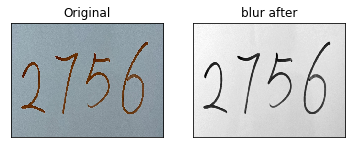

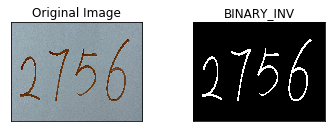

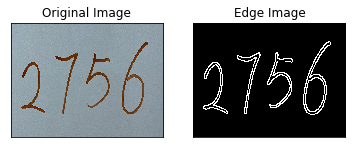

In [60]:
img, gray, blur, thresh, edges, dilate, contours = preprocess(image_path)

#cv.imwrite("original.png", img)
#cv.imwrite("gray.png", gray)
#cv.imwrite("blur.png", blur)
#cv.imwrite("thresh.png", thresh)
#cv.imwrite("edges.png", edges)
#cv.imwrite("dilate.png", dilate)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur,cmap = 'gray'),plt.title('blur after')
plt.xticks([]), plt.yticks([])
plt.show()

titles = ['Original Image','BINARY_INV']
images = [img, thresh]
for i in range(2):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dilate,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

## Find bounding boxes for each digit

In [61]:
from skimage import io
import numpy as np
def findBoundingBoxes(contours):
    rect = []
    # with each contour, draw boundingRect in blue
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv.boundingRect(c)
        #if w > 10 and h > 10:
        rect.append([x, y, w, h])
        # rect = np.array(rect).astype('float32')
    return rect

## Merge bounding boxes for each digit

In [62]:
def mergeBoundingBoxes(rect):
    for i in range(len(rect)):
        j = i + 1
        while j < len(rect):
            # check if rect[j] is within rect[i]
            # print(rect[j][0], ' ', rect[i][0], ' and ', rect[j][0]+rect[j][2], ' ', rect[i][0]+rect[i][2])
            # print(rect[j][1], ' ', rect[i][1], ' and ', rect[j][1]+rect[j][3], ' ', rect[i][1]+rect[i][3])
            xBound = rect[j][0] > rect[i][0] and rect[j][0]+rect[j][2] < rect[i][0]+rect[i][2]
            yBound = rect[j][1] > rect[i][1] and rect[j][1]+rect[j][3] < rect[i][1]+rect[i][3]
            if (xBound and yBound) == True:
                rect = np.delete(rect, j, 0)
                j = i + 1
            else:
                j = j + 1
    # sort bounding boxes on x-axis value
    rect = rect[rect[:,0].argsort()]
    return rect

In [63]:
rect = findBoundingBoxes(contours)
groupedRect = mergeBoundingBoxes(rect)

4


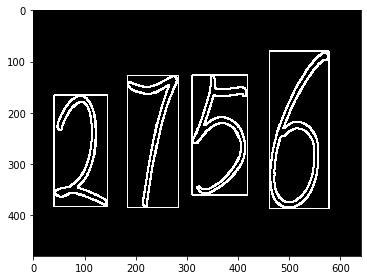

In [64]:
# draw a white rectangle to visualize the bounding rect
for row in groupedRect:
    cv.rectangle(dilate, (row[0], row[1]), (row[0]+row[2], row[1]+row[3]), (255, 0, 0), 2)
io.imshow(dilate)
cv.imwrite("boundingbox.png", dilate)
print(len(groupedRect))

## Extract ROI(Region of Interest) based on grouped bounding boxes

In [65]:
# Iterate thorugh bounding boxes and extract for ROI
def extractROI(image, groupedRect):
    digits = []
    original = image.copy()
    image_number = 0
    for rect in groupedRect:
        # add border to each digit
        ROI = original[rect[1]-20:rect[1]+rect[3]+20, rect[0]-20:rect[0]+rect[2]+20]
        digits.append(ROI)
        cv.imwrite("ROI_{}.png".format(image_number), ROI)
        image_number += 1
    return digits

In [66]:
digits = extractROI(thresh,groupedRect)

## Resize each digit image to be 28 x 28 and Normalize each digit image to between 0 - 1

In [67]:
def resizeAndNormalize():
    predInput = []
    for digit in digits:
        digit = cv.resize(digit, (28,28))
        digit = np.divide(digit, 255)
        predInput.append(digit.tolist())
    return predInput

In [68]:
predInput = resizeAndNormalize()

## Serialize and Deserialize Image in JSON

In [69]:
import json
import base64

image_path = os.path.join(os.getcwd(), 'test_images/test2.jpg')
with open(image_path, 'rb') as file:
    img = file.read()
image_64_encode = base64.encodebytes(img).decode('utf-8')

bytes_to_json = json.dumps(image_64_encode)

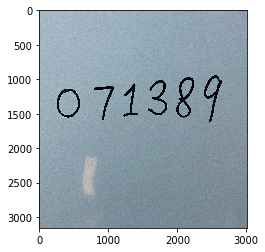

In [70]:
json_to_bytes = json.loads(bytes_to_json).encode('utf-8')

decoded_img = base64.decodebytes(json_to_bytes)
decoded_img = cv.imdecode(np.asarray(bytearray(decoded_img), dtype="uint8"), cv.IMREAD_COLOR) 
plt.imshow(decoded_img)
plt.show()
#with open('imgToPred.jpg', 'wb') as image_result:
#    image_result.write(decoded_img)